## Short tutorial on training and identification

Prepared by Liu Shuhui

E-mail: liushuhuibpt@126.com


The code used to Identify the atoms is developed based on atomai (https://github.com/pycroscopy/atomai). This notebook shows how to prepare the training dataset for TiO2, train the U-Net and get the result and coordinates.

In [1]:
import os.path
import atomidentification
from atomidentification.utils import create_lattice_mask, extract_patches_
from atomidentification.transforms import datatransform
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from openpyxl import *

In [2]:
#define the size of training data
batch_size_sum = 5000
tif_files = []
for foldername, subfolders, filenames in os.walk('D:/atomai-Identification/HRTEM'):

        tif_files.extend(glob.glob(os.path.join(foldername, '*.tif')))
        tif_files.extend(glob.glob(os.path.join(foldername, '*.jpg')))
length = len(tif_files)

batchnum_per_img =int(batch_size_sum/length)
images_all = []
labels_all = []



for file in tif_files:
    img = np.array(Image.open(file))
    if img.ndim == 3:
        img = img[:, :, 0]
    workbook =  load_workbook(file[0:-4]+'.xlsx')
    sheet = workbook['Sheet']
    coord = []
    for row in sheet.iter_rows(values_only=True):
            #coord110.append([int(np.round(x / 2)) for x in row])
            coord.append([x  for x in row])
    workbook.close()
    lattice_mask = create_lattice_mask(img, coord, scale=15, rmask=12 )


    images, labels = extract_patches_(
        img, lattice_mask, patch_size=256, num_patches=batchnum_per_img, random_state=42)
    images_all.append(images)
    labels_all.append(labels)

labels_all = np.array(labels_all)
images_all = np.array(images_all)

images_all = images_all.reshape(-1,images_all.shape[2],images_all.shape[3])
labels_all = labels_all.reshape(-1,labels_all.shape[2],labels_all.shape[3])

## Show the one example of images and labels

(4997, 256, 256) (4997, 256, 256)


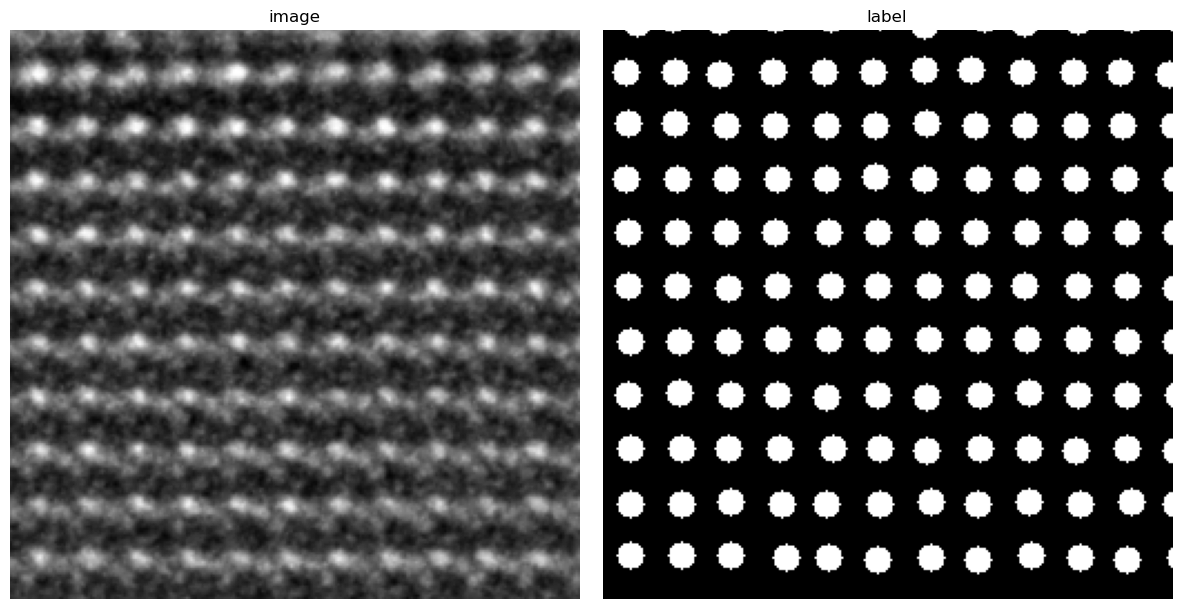

In [7]:
print(images_all.shape, labels_all.shape)

k = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
ax1.imshow(images_all[k], cmap='gray')
ax1.set_title('image')
ax1.axis('off')

ax2.imshow(labels_all[k], cmap='gray')
ax2.set_title('label')
ax2.axis('off')
plt.tight_layout()

plt.show()



## Image Augmentation through various processes including adding noises,blurring and contrast adjusting, etc.

In [13]:
# For a single class case, we still need to explicitly specify the single channel
labels_all = labels_all[..., None] if np.ndim(labels_all) == 3 else labels_all
# Number of channels in masked data (the training images have a single channel)
ch = labels_all.shape[-1]
# Define image distortion/noise parameters
zoom = 1.1 # zoom factor
poisson = [30, 50] # P noise range (scaled units)
gauss = [20, 100] # G noise range (scaled units)
blur = [1, 40] # Blurring range (scaled units)
contrast = [5, 14] # contrast range (< 10 is brighter, > 10 is darker)
salt_and_pepper = [1, 10] # min/max amount of salted/peppered pixels (scaled units)
# Run the augmentor
imaug = datatransform(
    n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first',
    gauss_noise=gauss, poisson_noise=poisson, salt_and_pepper=salt_and_pepper,
    contrast=contrast, blur=blur, zoom=zoom, rotation=True,
    squeeze_channels=True, seed=42)
images_all, labels_all = imaug.run(images_all, labels_all)
labels_all = np.squeeze(labels_all,axis=1)
print(images_all.shape, labels_all.shape)

(4997, 1, 256, 256) (4997, 256, 256)


## Show the example of images and labels after augmentation

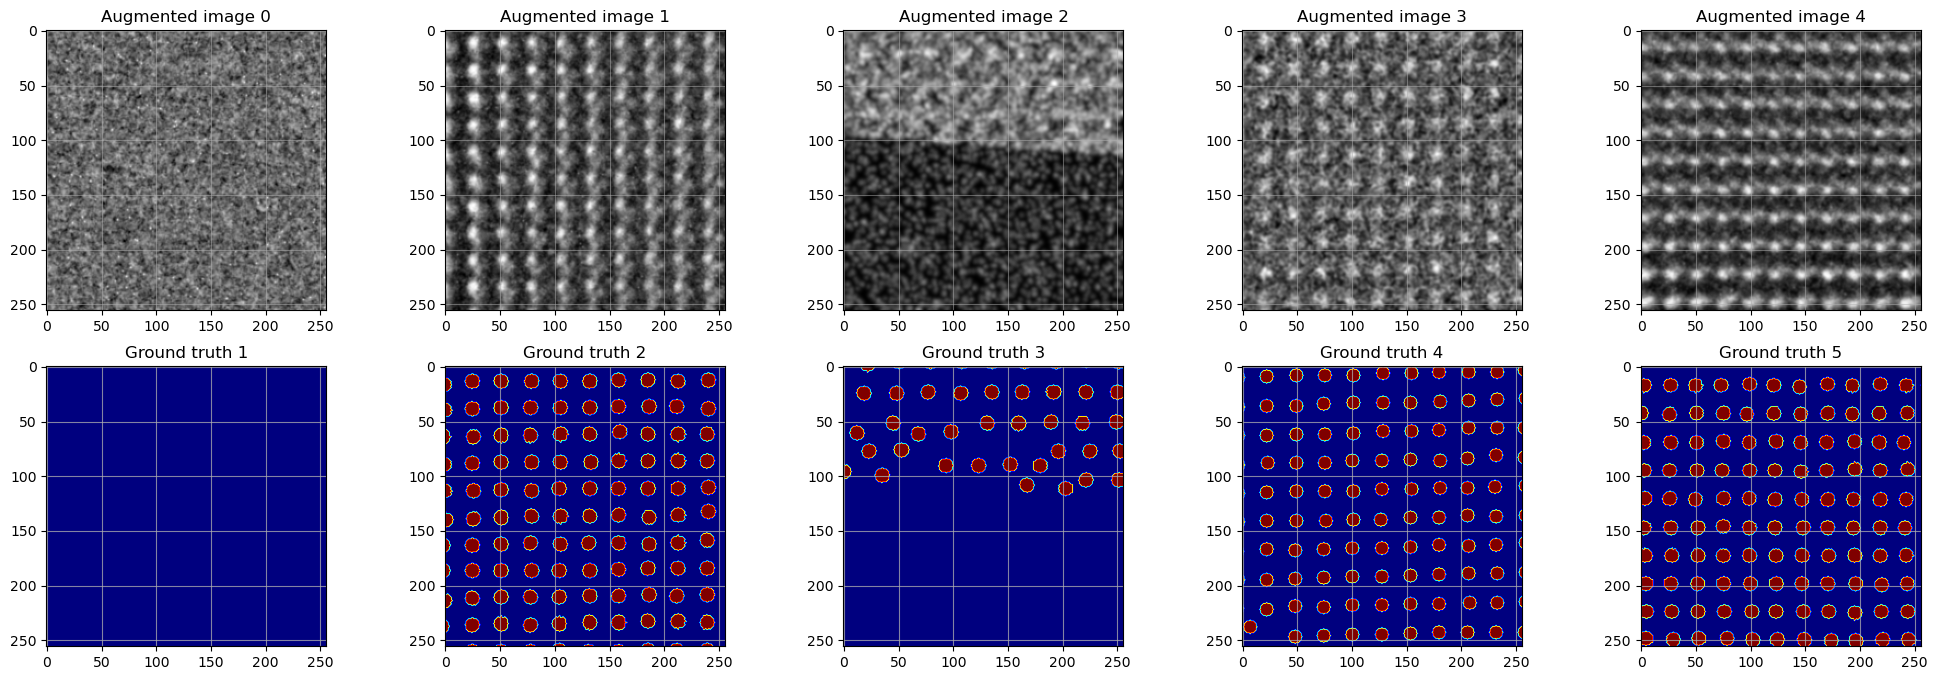

In [16]:
n = 6

fig = plt.figure( figsize=(30, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images_all[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i-1) )
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    if labels_all.shape[1] == 1:
        ax.imshow(labels_all[i-1, 0], cmap='jet', interpolation='Gaussian')
    else:
        ax.imshow(labels_all[i-1], cmap='jet', interpolation='Gaussian')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)
   # plt.show()
from sklearn.model_selection import train_test_split
images_all, images_test_all, labels_all, labels_test_all = train_test_split(
    images_all, labels_all, test_size=0.2, random_state=42)



np.savez('D:/atomai-master/datasets/newtest.npz',
         X_train=images_all, X_test=images_test_all, y_train=labels_all, y_test=labels_test_all)

## Train the U-Net after preparing the dataset

In [18]:
import atomidentification as aoi
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

dataset = np.load("D:/atomai-Identification/datasets/newtest.npz")


In [20]:
images = dataset['X_train']

labels = dataset['y_train']


images_test = dataset['X_test']
labels_test = dataset['y_test']


print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)

(3997, 1, 256, 256) (3997, 256, 256)
(1000, 1, 256, 256) (1000, 256, 256)


## Training.....

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

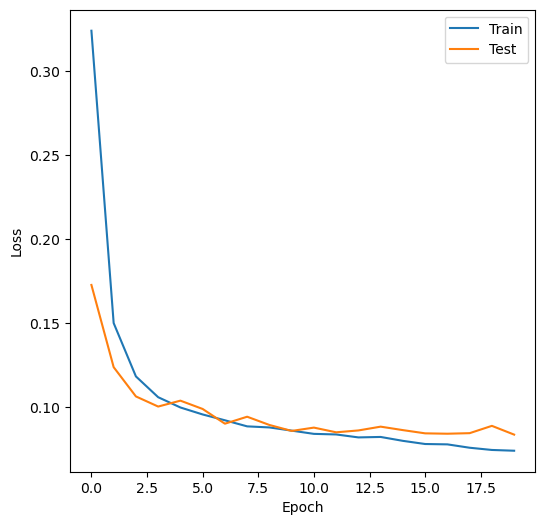

In [28]:
# plt.show()
model = aoi.models.Segmentor(nb_classes=1)
#model = torch.load('D:/atomai-master/model/model_newtest.pt')
print(model.net)

model.fit(images, labels, images_test, labels_test,  # training data
          training_cycles=20, full_epoch = True, batch_size=28, compute_accuracy=True, swa=True  # training parameter
          )

torch.save(model, 'D:/atomai-Identification/model/model_newtest4.pt')

## Predict the images using the trained model: model_newtest4.pt

In [30]:
import atomidentification as aoi
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image, ImageDraw
from openpyxl import *

In [31]:
path = r'D:/atomai-Identification/images/'
model = torch.load('D:/atomai-Identification/model/model_newtest4.pt')
radius = 4

filename = os.listdir(path)
for file in filename:
    current_path = os.path.join(path,file)
    img = Image.open(current_path)
    img = np.array(img)
    print(file)
    if img.ndim == 3:
        img = img[:, :, 0]
    # plt.imshow(img, cmap='gray')
    # plt.show()
    nn_output, coordinates = model.predict(img, refine=True, thresh=0.4, d=20)
    # _, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
    # ax1.imshow(img, cmap='gray')
    # ax2.imshow(nn_output.squeeze())
    #
    # aoi.utils.plot_coord(img, coordinates[0], fsize=12)
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    for coord in coordinates[0]:
        y, x, c = coord.T
        bounding_box = (x - radius, y - radius, x + radius, y + radius)
        # draw atoms
        draw.ellipse(bounding_box, fill= "white")
    #save the segmentation result
    img.save('D:/atomai-Identification/images-result/'+file[0:-4]+'.png')
    wb = Workbook()
    ws = wb['Sheet']
    #atomsXY = coordinates[0][:, 0:2]
    atomsXY = coordinates[0][:,0:2].tolist()
    for row in atomsXY:
        ws.append(row)
    #save the coordinates
    wb.save('D:/atomai-Identification/images-label/' + file[0:-4] + '.xlsx')
    wb.close()

300O2.tif
Batch 1/1
Refining atomic positions... Done

1 image was decoded in approximately 31.874 seconds
450O2_4_200fps.tif
Batch 1/1
Refining atomic positions... Done

1 image was decoded in approximately 37.8143 seconds
450O2_6.tif
Batch 1/1
Refining atomic positions... Done

1 image was decoded in approximately 43.4583 seconds


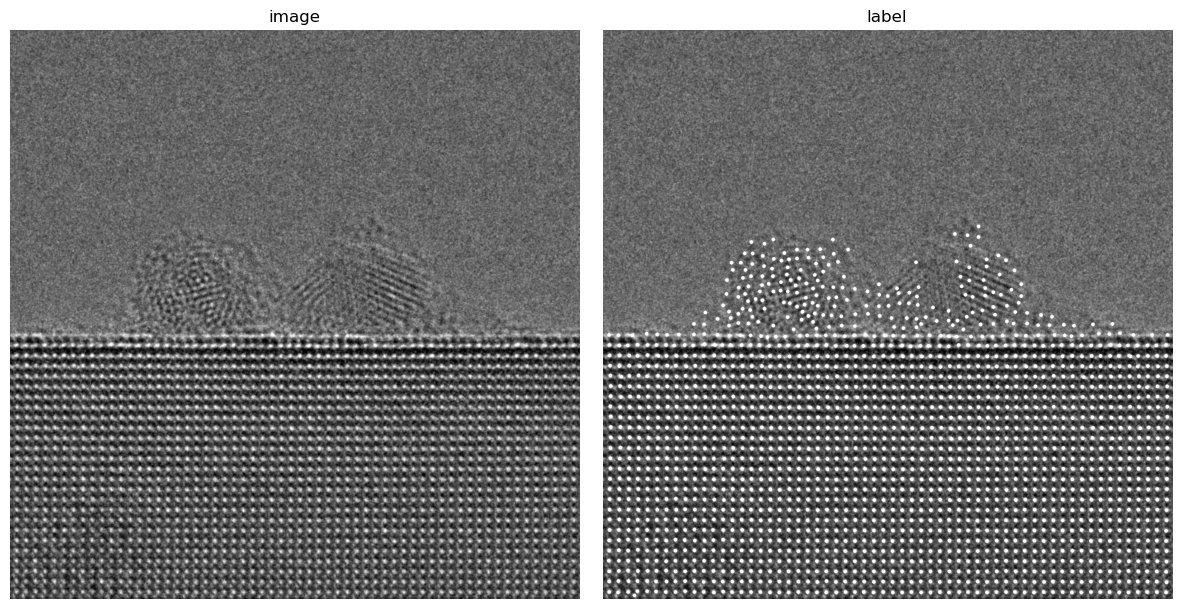

In [33]:
#show the segmentation result



image1=Image.open("D:/atomai-Identification/images/300O2.tif")
result1=Image.open("D:/atomai-Identification/images-result/300O2.png")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
ax1.imshow(image1, cmap='gray')
ax1.set_title('image')
ax1.axis('off')

ax2.imshow(result1, cmap='gray')
ax2.set_title('label')
ax2.axis('off')
plt.tight_layout()

plt.show()